# 미국 소매 판매량 예측 #

[*미국 소매 판매량*](https://www.census.gov/retail/index.html)은 1992년부너 2019년까지의 월별 소매시장의 판매량에 대한 데이터로, 이전 연도의 판매량을 통해 다음 연도의 판매량을 예측하는 모델을 생성하겠습니다.

### 1. 데이터 불러오기

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
import util

retail = pd.read_csv("./dataset/us-retail-sales.csv", usecols=['Month', 'FoodAndBeverage'],
    parse_dates=['Month'], index_col='Month').to_period('D')
retail.head()

,FoodAndBeverage
Month,
1992-01-01,29589
1992-02-01,28570
1992-03-01,29682
1992-04-01,30228
1992-05-01,31677


## 모델 1 - 선형회귀

### 2. 데이터 전처리

<AxesSubplot:xlabel='Month'>

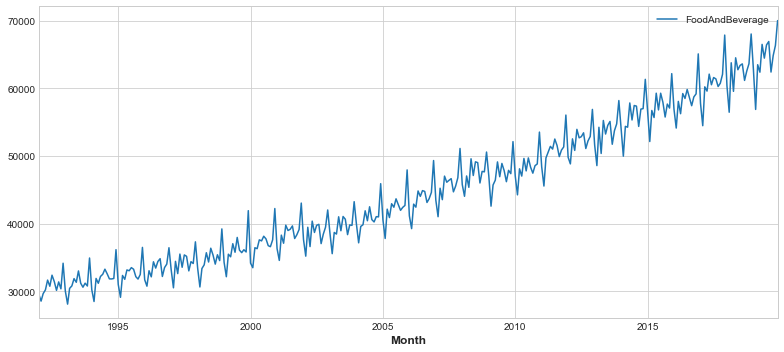

In [2]:
y = retail.copy()
util.init_plt()
y.plot()

포물선을 띄는 형태로 증가하고 있으므로, 2차원의 트렌드 변수를 생성합니다.

In [3]:
dp = DeterministicProcess(index=y.index, constant=True, order=2 , drop=True)    
X = dp.in_sample()
X.head()

,const,trend,trend_squared
Month,,,
1992-01-01,1.0,1.0,1.0
1992-02-01,1.0,2.0,4.0
1992-03-01,1.0,3.0,9.0
1992-04-01,1.0,4.0,16.0
1992-05-01,1.0,5.0,25.0


**데이터 분할**


4년치 데이터(2016~2019)를 테스트용으로 설정합니다. 

인덱스를 기준으로 분할하고, 해당 인덱스에 해당하는 값을 학습용 데이터와 테스트용 데이터로 설정합니다.

In [4]:
idx_train, idx_test = train_test_split(y.index, test_size=12 * 4, shuffle=False)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

### 3. 학습 - 선형회귀

In [5]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

### 4. 예측

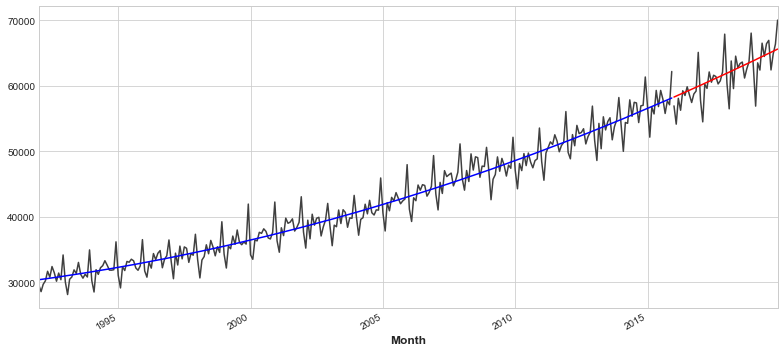

In [6]:
y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=y_test.index, columns=y_test.columns)

axs = y_train.plot(color='0.25', subplots=True, sharex=True, legend=False)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, legend=False, ax=axs)
axs = y_fit.plot(color='blue', subplots=True, sharex=True, legend=False, ax=axs)
axs = y_pred.plot(color='red', subplots=True, sharex=True, legend=False, ax=axs)

## 모델 2 - XGBoost

XGBoostRegressor를 사용하여 계절성을 예측하는 모델을 생성합니다.

### 2. 데이터 전처리

In [7]:
X = retail.copy()
X["Month"] = X.index.month  
X.head()

,FoodAndBeverage,Month
Month,,
1992-01-01,29589,1
1992-02-01,28570,2
1992-03-01,29682,3
1992-04-01,30228,4
1992-05-01,31677,5


In [8]:
# 종속변수, 독립변수 할당
y = X['FoodAndBeverage'] 
X = X.drop(['FoodAndBeverage'],axis=1,inplace=False)

In [9]:
# 데이터 분할
X_train, X_test = X.loc[idx_train], X.loc[idx_test]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

<AxesSubplot:xlabel='Month'>

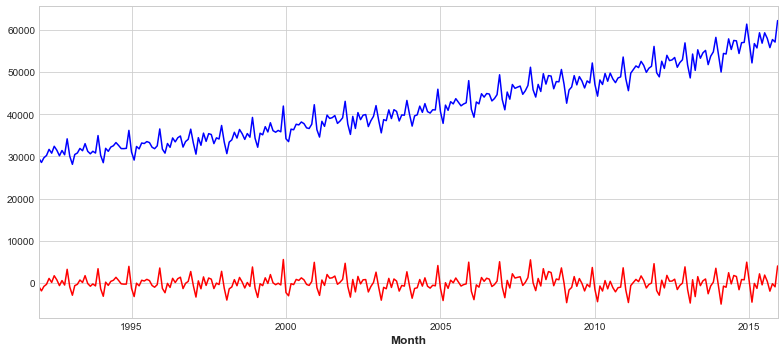

In [10]:
# 종속변수(타겟변수)를 y_train(실제값)에서 선형회귀에서 학습한 부분(y_fit)을 제외한 값으로 설정
y_resid = y_train - y_fit['FoodAndBeverage']
y_train.plot(color = 'blue')
y_resid.plot(color = 'red')

### 3. 학습 - XGBoost

In [11]:
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 4. 예측

In [12]:
y_fit_boosted = xgb.predict(X_train) + y_fit['FoodAndBeverage']
y_pred_boosted = xgb.predict(X_test) + y_pred['FoodAndBeverage']

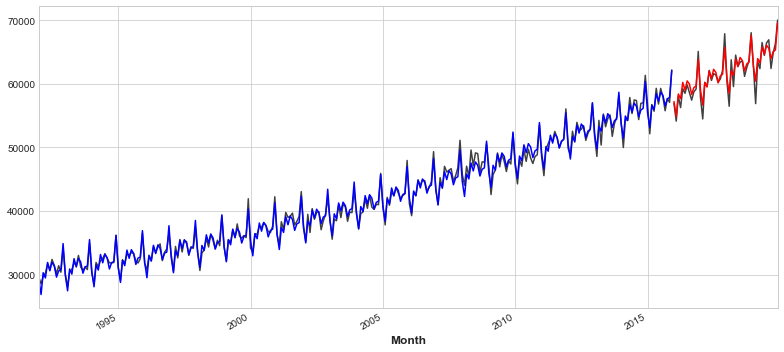

In [13]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True, legend=False)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, legend=False, ax=axs)
axs = y_fit_boosted.plot(color='blue', subplots=True, sharex=True, legend=False, ax=axs)
axs = y_pred_boosted.plot(color='red', subplots=True, sharex=True, legend=False, ax=axs)